<a id="top"></a>
[Go to the bottom](#bottom)
---

## Import libraries

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from zipfile import ZipFile
import requests

import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

from datetime import datetime

## Get dataset

In [2]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
FILE_PATH_SEATTLE = os.path.join(DATA_PATH, 'seattle.zip')
FILE_PATH_BOSTON = os.path.join(DATA_PATH, 'boston.zip')

In [3]:
def extract_df_from_airbnb_zipfile(PATH_ZIPFILE) :
    '''
        INPUT : file path to a zipfile to open
        OUTPUT : a dictionary that contains dataframes of files 
        extracted from the zip file
    '''

    zf = ZipFile(PATH_ZIPFILE) 
    dfs = {
        text_file.filename : pd.read_csv(zf.open(text_file.filename ))
        for text_file in zf.infolist() 
        if text_file.filename.endswith('.csv')
    }
    
    print('Printing a dictionary with filenames as keys')
    for filename in dfs.keys() :
        print(f'Filename (keys): {filename}')
    
    return dfs

In [4]:
dfs_sea = extract_df_from_airbnb_zipfile(FILE_PATH_SEATTLE)

Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv


In [5]:
listings_sea = dfs_sea['listings.csv']
reviews_sea = dfs_sea['reviews.csv']
calendar_sea = dfs_sea['calendar.csv']

---
<a id="function"></a>
## Functions
Collect all functions to use in this notebook.

In [6]:
# Helper function
def convert_str_to_datetime(df, date_feature) :

    date_conversion = lambda x : datetime.strptime(x, "%Y-%m-%d")
    
    return df[date_feature].apply(date_conversion)
    

def break_date(df, date_feature) :

    df_new = df.copy()
    
    df_new[date_feature] = convert_str_to_datetime(df_new, date_feature)

    df_new['year'] = df_new[date_feature].apply(lambda x : x.year)
    df_new['month'] = df_new[date_feature].apply(lambda x : x.month)
    df_new['day'] = df_new[date_feature].apply(lambda x : x.day)
    
    return df_new
    

In [7]:
def convert_price_float(series) :

    # Remove $ & , sign from price
    rep = {'$':'', ',': ''}

    for old, new in rep.items() :
        series = series.str.replace(old, new)
        
    # convert date type to float
    series = series.astype(float)
    
    return series

In [8]:
def convert_binary_num(series) :
    
    series = series.map({
        't': 1, 'f':0
    })
    
    return series

In [9]:
def plot_line_chart(x, height, layout_obj=False, rotation=False) :

    if ( layout_obj ) and ( not len(layout_obj) == 3 ): 
        print('Length of layout_obj must be 3')
        raise 
    
    title, xlabel, ylabel = layout_obj.values()
    
    plt.figure(figsize=(10,4))
    plt.plot(x, height, marker='o')

    plt.title(title)
    plt.xlabel(xlabel);
    plt.ylabel(ylabel)
    plt.axhline(height.mean(), c='orange', ls='--')
    
    if rotation : 
        plt.xticks(rotation=45);

    plt.show()

In [10]:
def plot_bar_chart(x, height, layout_obj=False, rotation=False) :

    if ( layout_obj ) and ( not len(layout_obj) == 3 ): 
        print('Length of layout_obj must be 3')
        raise 
    
    title, xlabel, ylabel = layout_obj.values()
    
    plt.figure(figsize=(10,4))
    plt.bar(x, height)

    plt.title(title)
    plt.xlabel(xlabel);
    plt.ylabel(ylabel)
    
    if rotation : 
        plt.xticks(rotation=45);

    plt.show()

In [11]:
def map_calendar_month(series) :
    
    try : 
        series = series.map({
            1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
            7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
        })
        
        return series
        
    except :
        print('Failed mapping')
        return

In [12]:
def create_points_geometry(series1, series2) :
    """ Create points from longitude, latitude data 
    using GeoPandas module    
        
    arg: 
        series1 : longitude data series
        series2 : latitude data series
        
    return: 
        transformed geometry list which will be used 
        as a parameter of GeoDataFrame
    """
    
    return [Point(xy) for xy in zip(series1, series2)]
    

[Go to the bottom](#bottom)

---
## Data exploration
The respective Airbnb datasets are downloaded from : 

- Seattle : https://www.kaggle.com/airbnb/seattle
- Boston  : https://www.kaggle.com/airbnb/boston



### Content
- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

### Inspiration
- Can you describe the vibe of each Seattle neighborhood using listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

Reference to the real use of the data: http://insideairbnb.com/seattle/

## `1.` Occupancy rate & price through the year
Working with **`calendar`** dataframe for both Seattle and Boston airbnb dataset. I will work on Seattle data first and subsequently apply a function for wrangling and visualizing Boston data.

### Data cleaning & exploration

In [13]:
# Copy a dataframe for data cleaning
calendar = calendar_sea.copy() 

In [14]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [15]:
# Data for 365 days from 2016-01-04 - 2017-01-02
len(calendar.date.value_counts().index) 

365

In [16]:
# Convert t, f to binary int : available
calendar.available = convert_binary_num(calendar.available)

In [17]:
# Remove $ & , sign from price
calendar.price = convert_price_float(calendar.price)

In [18]:
# Occpancy rate and price per day 
occ_price_tbl = calendar.groupby('date').mean().drop(columns='listing_id')
occ_price_tbl.columns = ['occ_rate', 'avg_rate']
occ_price_tbl.describe()

,occ_rate,avg_rate
count,365.000000,365.000000
mean,0.670610,137.901783
std,0.047899,9.860142
min,0.454426,117.685413
25%,0.647197,132.446443
50%,0.674961,136.731206
75%,0.702462,146.930502
max,0.765322,157.480000


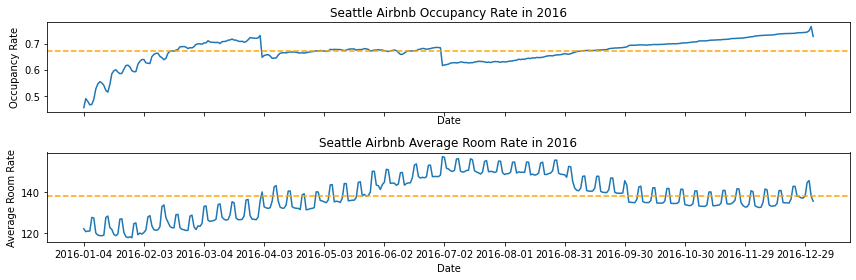

In [19]:
ticks = np.arange(0, len(occ_price_tbl.index)+1, 30)
labels = [occ_price_tbl.index[idx] for idx in ticks]

date = occ_price_tbl.index
rate_dict = [{'data': occ_price_tbl.occ_rate, 'desc': 'Occupancy Rate'},
             {'data': occ_price_tbl.avg_rate, 'desc': 'Average Room Rate'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,4))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'])
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].set_xticks(labels) 
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1.5)
    
    fig.tight_layout()

plt.show()

In Seattle, the occupancy rate starts to increase from the beginning of 2016 until its first peak around early-April. It suddenly dips right after the April peak and stays idle until its second dip on early July. After that the trend starts to rise until the end of the year. 

When it comes to average room rate, it starts to increase from the beginning of the year until its peak near July. The room rate stays in the highest level for nearly 2 months until it slowly decreases and remains on the average level. 

Next, I will break the dates down into year, month and day for more detailed analysis.

### Converting date from string to datetime object

In [20]:
# Convert into datetime object : date
date_conversion = lambda x : datetime.strptime(x, "%Y-%m-%d")
calendar.date = calendar.date.apply(date_conversion)

In [21]:
calendar.insert(2, 'year', calendar.date.apply(lambda x : x.year))
calendar.insert(3, 'month', calendar.date.apply(lambda x : x.month))
calendar.insert(4, 'day', calendar.date.apply(lambda x : x.day))

<font color='#d9534f'>The above codes take too much time, which will be improved for any later use with `break_date` function</font>

### Trend of Occupancy rate and average room rate in 2016
Monthly, Airbnb Seattle

In [22]:
analysis_seattle = calendar.groupby('month').mean()[['available', 'price']]
analysis_seattle.head()

,available,price
month,,
1,0.566937,122.912176
2,0.662208,124.293927
3,0.709187,128.644488
4,0.663847,135.097005
5,0.675670,139.538183


In [23]:
# Mapping integers to month name
analysis_seattle.index = map_calendar_month(analysis_seattle.index)

# Change column names
analysis_seattle.columns = ['occ_rate', 'room_rate']

# Confirm the change
analysis_seattle.head()

,occ_rate,room_rate
month,,
Jan,0.566937,122.912176
Feb,0.662208,124.293927
Mar,0.709187,128.644488
Apr,0.663847,135.097005
May,0.675670,139.538183


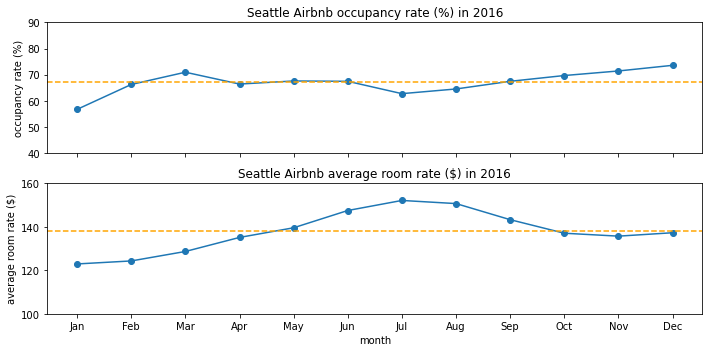

In [24]:
date = analysis_seattle.index
rate_dict = [{'data': analysis_seattle.occ_rate, 'desc': 'occupancy rate (%)'},
             {'data': analysis_seattle.room_rate, 'desc': 'average room rate ($)'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 5))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'], marker='o')
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1.5)


axes[1].set_xlabel('month')    
fig.tight_layout()

axes[0].set_yticks(np.arange(0.4, 0.8 + 0.2, 0.1))
axes[0].set_yticklabels([str(occ) for occ in range(40, 80 + 20, 10)])

axes[1].set_yticks(np.arange(100, 160 + 20, 20))
axes[1].set_yticklabels([str(price) for price in range(100, 160 + 20, 20)])

plt.show()

The occupancy rate starts with the lowest level below 60% in the beginning of the year, and follows the increasing trend until March. As seen previously, there was a sudden dip April, which took effect in the occupancy rate in that month. The occupancy rate in July stays below the year's average level and it continues on in August. However, it gets recovered until its peak in December. 

Average room rates peak up in the summer period from Jun to August, whilst the higher price level may explain the lower occupancy level during the same period. However, is it good or bad? It is hard to see the performance by seperating the occupany rate and average room rate, and there is a metric that the hotel industry uses to measure the business performance, called RevPar.

 ### How about RevPar ? 

RevPAR, or revenue per available room, is a performance metric in the hotel industry that is calculated by dividing a hotel's total guestroom revenue by the room count and the number of days in the period being measured. https://en.wikipedia.org/wiki/RevPAR

It can alternatively be calculated as occupancy rate $(# room occupied / # available) x average room rate$.

In [25]:
analysis_seattle['revpar'] = ( analysis_seattle.occ_rate 
                                * analysis_seattle.room_rate )

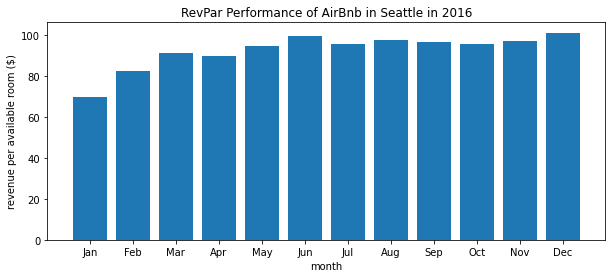

In [26]:
date = analysis_seattle.index
revpar = analysis_seattle['revpar']
layout_obj = {
    'title': 'RevPar Performance of AirBnb in Seattle in 2016',
    'xlabel': 'month',
    'ylabel': 'revenue per available room ($)'
}

plot_bar_chart(date, revpar, layout_obj, rotation=False)

plt.show()

In [27]:
analysis_seattle['revpar'].sort_values(ascending=False)

month
Dec    100.958803
Jun     99.453597
Aug     97.181255
Nov     96.879911
Sep     96.612092
Oct     95.444659
Jul     95.377854
May     94.281823
Mar     91.233047
Apr     89.683700
Feb     82.308439
Jan     69.683499
Name: revpar, dtype: float64

The RevPar is \\$99.45 in June, which is the second highest level through the year. It looks that the decrease in occupancy rate in August affected the RevPar but the performance in August is not too bad with \\$97.18. 

RevPar performance is quite steady from Q3 onwards, but a further study seems necessary to figure out why it started low in the beginning of the year. Supposedly there was a series of concerns around Airbnb that may have affected the confidence from consumer and hosts, as following:

- Concerns over the company's affecting the local housing market affordability and some political consideration were expected whether to regulate the company's activity: [source1](https://www.seattletimes.com/business/airbnb-says-its-rentals-arent-affecting-housing-affordability/) [source2](https://www.geekwire.com/2016/seattle-regulates-airbnb-company-releases-study-showing-178m-annual-impact-local-economy/)

- Airbnb will start collecting taxes in Washington state: [source](https://www.geekwire.com/2015/airbnb-will-start-collecting-taxes-in-washington-state-on-behalf-of-hosts)

---
### Extend the analysis to Boston data
Create a function for wrangling

In [40]:
def wrangle_airbnb_calendar_data(df) :
    
    # check if df has airbnb 'calendar' data
    if (df.shape[1] != 4 or df.columns.values[0] != 'listing_id') :
        print('Check if input dataframe is correct or data format has been changed')
        return 
    
    calendar = df.copy() 
    calendar.available = convert_binary_num(calendar.available)    
    calendar.price = convert_price_float(calendar.price)
    
    calendar_new = break_date(calendar, 'date')

    monthly_analysis = calendar_new.groupby('month').mean()[['available', 'price']]
    monthly_analysis.index = map_calendar_month(monthly_analysis.index)
    monthly_analysis.columns = ['occ_rate', 'room_rate']
    
    monthly_analysis['revpar'] = ( monthly_analysis.occ_rate 
                                   * monthly_analysis.room_rate )
    
    return monthly_analysis
    

### Get Boston data & wrangle it

In [41]:
# Extract airbnb Boston 'calendar' data
df_bos = extract_df_from_airbnb_zipfile(FILE_PATH_BOSTON)

Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv


In [42]:
calendar_bos = df_bos['calendar.csv']
listings_bos = df_bos['listings.csv']
reviews_bos = df_bos['reviews.csv']

In [43]:
analysis_boston = wrangle_airbnb_calendar_data(calendar_bos)

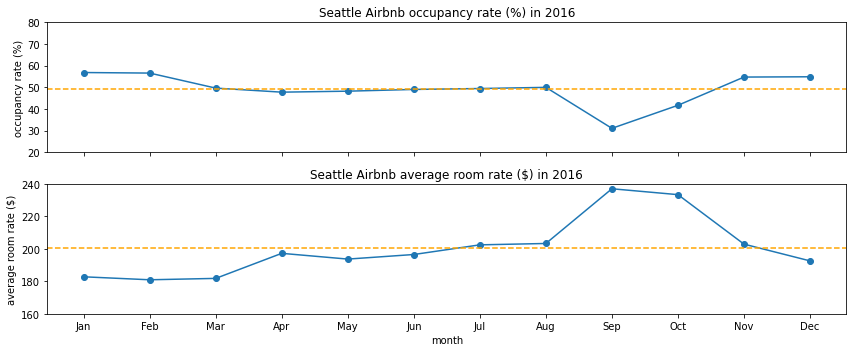

In [44]:
date = analysis_boston.index
rate_dict = [{'data': analysis_boston.occ_rate, 'desc': 'occupancy rate (%)'},
             {'data': analysis_boston.room_rate, 'desc': 'average room rate ($)'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,5))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'], marker='o')
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1.5)

axes[1].set_xlabel('month')    
fig.tight_layout()

axes[0].set_yticks(np.arange(0.2, 0.8, 0.1))
axes[0].set_yticklabels([str(occ) for occ in range(20, 80 + 10, 10)])

axes[1].set_yticks(np.arange(160, 240 + 20, 20))
axes[1].set_yticklabels([str(price) for price in range(160, 240 + 20, 20)])

plt.show()

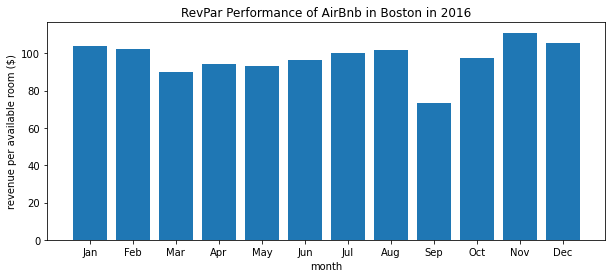

In [45]:
date = analysis_boston.index
revpar = analysis_boston['revpar']
layout_obj = {
    'title': 'RevPar Performance of AirBnb in Boston in 2016',
    'xlabel': 'month',
    'ylabel': 'revenue per available room ($)'
}

plot_bar_chart(date, revpar, layout_obj, rotation=False)

plt.show()

Boston\'s RevPar performance looks high during the winter period (Nov - Feb), whereas the lowest RevPar was observed in September 2016. 

### Comparison of revpar between Seattle and Boston

In [47]:
revpar_analysis_airbnb = pd.DataFrame({
    'revpar_seattle' : analysis_seattle.revpar,
    'revpar_boston'  : analysis_boston.revpar
}, index=analysis_seattle.index)

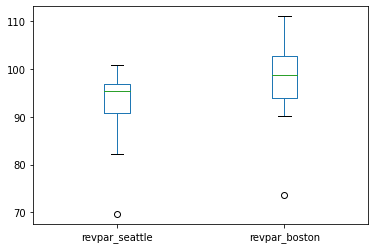

In [52]:
revpar_analysis_airbnb.boxplot(grid=False);

RevPar performance in Boston higher than in Seattle with higher variance throughout the year 2016.

---
## `2`. Trend in listing
Now to discover the supply side 

- \# of new hostings : `host_since`
- \# of hostings(at point in time) : `calculated_host_listings_count`
- growth of super_host : `host_is_superhost`
- hosting type: [`property_type`, `room_type`, `price`, ...]

In [53]:
# Copy a dataframe for data cleaning
listings = listings_sea.copy() 
listings.shape

(3818, 92)

In [54]:
cols_host = listings.loc[:, listings.columns.str.contains('host')]
extra_info = listings[['property_type', 'room_type', 'price']]

host_original = cols_host.join(extra_info)
print(host_original.shape)
host_original.head()

(3818, 22)


,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,property_type,room_type,price
0,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,2,Apartment,Entire home/apt,$85.00
1,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,6,Apartment,Entire home/apt,$150.00
2,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,...,Queen Anne,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,2,House,Entire home/apt,$975.00
3,9851441,https://www.airbnb.com/users/show/9851441,Emily,2013-11-06,"Seattle, Washington, United States",NaN,NaN,NaN,NaN,f,...,Queen Anne,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,1,Apartment,Entire home/apt,$100.00
4,1452570,https://www.airbnb.com/users/show/1452570,Emily,2011-11-29,"Seattle, Washington, United States","Hi, I live in Seattle, Washington but I'm orig...",within an hour,100%,NaN,f,...,Queen Anne,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,1,House,Entire home/apt,$450.00


### Data cleaning

#### Drop unnessary / repetitive features
return host_clean_v0 dataframe

In [55]:
# drop unnecessary cols
# calculated_host_listings_count are more accurate info
drop_cols = ['host_url', 'host_thumbnail_url', 'host_picture_url', 'host_verifications',
             'host_has_profile_pic', 'host_listings_count', 'host_total_listings_count']
host_clean_v0 = host_original.drop(columns = drop_cols).copy()

In [56]:
#pd.options.display.max_row = None
#host[host.duplicated(subset=['host_id'], keep=False)].sort_values(by='host_id')

#### Drop duplicates

It looks that host_id is duplicated when a host has more than 1 hosting. Drop duplicates by host_id (not host_name!). 72% remain after removing duplicated rows, but it is rational to drop, and keep the last row (latest).

return host_clean_v1 dataframe

In [57]:
( host_clean_v0.drop_duplicates(subset=['host_id'], keep='last').shape[0] 
 / host_clean_v0.shape[0] )

0.7205343111576742

- There are rows with no information, which is to be removed. 
- `host_since` feature needs conversion to date time object. 

In [58]:
# Drop duplicates
host_clean_v1 = host_clean_v0.drop_duplicates(subset=['host_id'], keep='last')

#### Drop missing values

return host_clean_v2 dataframe

In [59]:
# Drop 2 missing values
host_clean_v1[host_clean_v1['host_since'].isnull()]

,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_identity_verified,calculated_host_listings_count,property_type,room_type,price
1297,42515980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Apartment,Entire home/apt,$99.00
1419,1075031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Apartment,Entire home/apt,$250.00


In [60]:
host_clean_v2 = host_clean_v1[host_clean_v1['host_since'].notnull()]

#### Change to relevant data type
return host_clean_v3 dataframe

In [61]:
# Convert into date time object
print(host_clean_v2.shape)
host_clean_v3 = break_date(host_clean_v2, 'host_since')

(2749, 15)


In [62]:
print(host_clean_v3.shape) 
#host_clean_v3.info()
#host_clean_v3.head()

(2749, 18)


In [63]:
host = host_clean_v3

---
### Create a function for wrangling
Checked if seattle and boston dataframe share all features in common : there are three features that Seattle listings dataset do not have, which however are not relevant for this analysis.

In [64]:
#listings_bos.columns.isin(listings_sea.columns)
listings_bos.columns[12:15]

Index(['access', 'interaction', 'house_rules'], dtype='object')

In [65]:
def wrangle_airbnb_host_data(df) :
    
    # Check if input dataframe is 'listings' dataset
    # Three three key columns must be inside the dataframe
    key_cols= ['host_id', 'host_since', 'calculated_host_listings_count']
    
    if df.columns.isin(key_cols).sum() !=3 :
        print('Check if input dataframe is correct or data format has been changed')
        return 
    
    print(f'Original dataframe has {df.shape[0]} x {df.shape[1]} dataset')
    
    df_copy = df.copy()
    
    # Drop uncessary columns
    host_related  = df.loc[:, df.columns.str.contains('host')]
    extra_info = df[['property_type', 'room_type', 'price']]
    
    host_df = host_related.join(extra_info)
    drop_cols = ['host_url', 'host_thumbnail_url', 'host_picture_url', 'host_verifications',
                 'host_has_profile_pic', 'host_listings_count', 'host_total_listings_count']
    host_df = host_df.drop(columns = drop_cols)
    
    # Drop duplicates
    host_df = host_df.drop_duplicates(subset=['host_id'], keep='last')
    
    # Drop null 
    host_df = host_df[host_df['host_since'].notnull()]
    
    # Convert into date time object
    host_df = break_date(host_df, 'host_since')
    
    
    print(f'After wrangling : returning {host_df.shape[0]} x {host_df.shape[1]} dataset')
    
    return host_df
    

In [66]:
host_seattle = wrangle_airbnb_host_data(listings_sea)
host_boston = wrangle_airbnb_host_data(listings_bos)

Original dataframe has 3818 x 92 dataset
After wrangling : returning 2749 x 18 dataset
Original dataframe has 3585 x 95 dataset
After wrangling : returning 2181 x 18 dataset


### How has number of hosing grown year on year?

In [67]:
new_hosting_seattle = host_seattle.groupby('year').count()['host_id']
new_hosting_boston = host_boston.groupby('year').count()['host_id']

In [68]:
analysis_new_hostings = pd.concat([new_hosting_seattle.rename('new_hosting_seattle'), 
                                   new_hosting_boston.rename('new_hosting_boston')], axis=1)

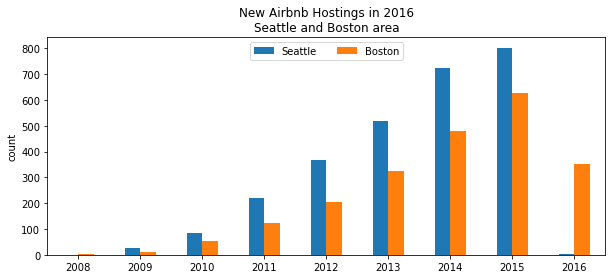

In [69]:
analysis_new_hostings.plot.bar(figsize=(10,4))

plt.title('New Airbnb Hostings in 2016\nSeattle and Boston area')
plt.xlabel('')
plt.ylabel('count')
plt.xticks(rotation=0)
plt.legend(labels=['Seattle', 'Boston'], loc='upper center', ncol=6)

plt.show()

The joining of new hosts has been growing rapidly (can say exponentially) since the establishment of Airbnb (2008) in both Seattle and Boston markets. The number of new hostings is larger in Seattle than Boston - may be due to lots of reasons i.e. more favourable regulation, demographic, market acitivities, etc. 
|
However, the new hostings became significantly idle in 2016 for both Seattle and Boston markets. This may be resulted from error in data collection but assuming data is super reliable, new regulatatory move and tax policy may have made potential hosts to be more cautious in renting out their properties, especially in Seattle.

### General hosting statistics 
To gain insights into hostings : `superhost`, `property_type`, `room_type`, `price`

### How much percentage superhost accounts for?

In [111]:
is_superhost_sea = host_seattle.host_is_superhost.value_counts()
is_superhost_bos = host_boston.host_is_superhost.value_counts()

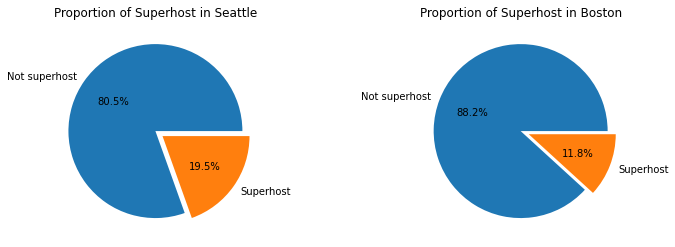

In [115]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

ax1.pie(is_superhost_sea, labels=['Not superhost', 'Superhost'], autopct='%1.1f%%', explode=(0, 0.1))
ax2.pie(is_superhost_bos, labels=['Not superhost', 'Superhost'], autopct='%1.1f%%', explode=(0, 0.1))

ax1.set_title(f'Proportion of Superhost in Seattle')
ax2.set_title(f'Proportion of Superhost in Boston')

plt.show()

Nearly 20% of the total hostings are made by Superhost. According to Aibnb, "Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests." [Reference](https://www.airbnb.com/help/article/828/what-is-a-superhost)

To retain Superhost status, hosts should satisfies the performance standards and other qualifications for the most recent 12 months from the review date. [Reference](https://www.airbnb.com/superhost/terms) This suggests that superhosts represent dedicated propertiy suppliers in a fairly consistent manner.

20% of the listings were provided by superhosts in Seattle, which is a high proportion of decidated and consistent supplies of Airbnb rooms (subjectively speaking, and needs further studies to confirm) and may partially explain the fast growth of Airbnb in the market.

### Property type

In [76]:
property_type_seattle = host_seattle.property_type.value_counts()
property_type_boston = host_boston.property_type.value_counts()

<ipython-input-77-f73adbee5489>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(property_type_seattle.index, rotation=90)


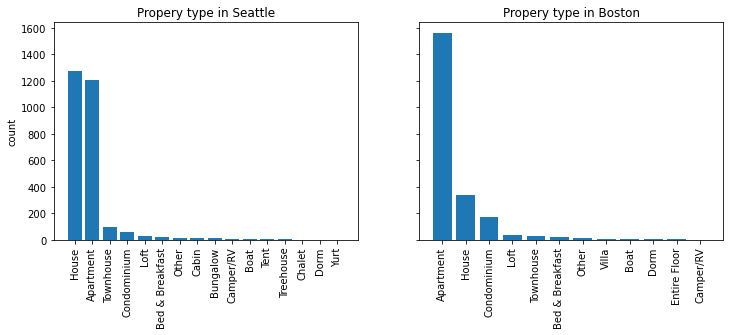

In [77]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

ax1.bar(property_type_seattle.index, property_type_seattle.values)
ax2.bar(property_type_boston.index, property_type_boston.values)

ax1.set_title(f'Propery type in Seattle')
ax2.set_title(f'Propery type in Boston')
ax1.set_ylabel('count')

# Two different ways to set xticks in subplot
ax1.set_xticklabels(property_type_seattle.index, rotation=90)
    
for tick in ax2.get_xticklabels() :
    tick.set_rotation(90) 

In 2016, House (46%) and Apartment (44%) were the most common types of properties in Seattle, whereas large proportion of hosts (nearly 72% of total) offered Apartment in Boston.

### Room type

In [78]:
room_type_seattle = host_seattle.room_type.value_counts()
room_type_boston = host_boston.room_type.value_counts()

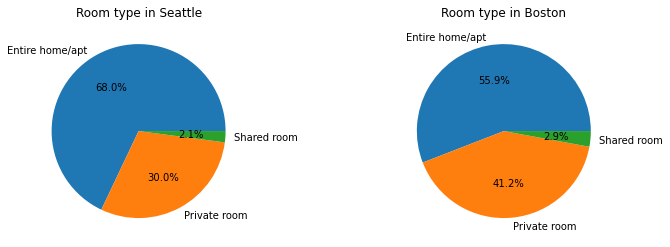

In [79]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

ax1.pie(room_type_seattle.values, labels=room_type_seattle.index, autopct='%1.1f%%')
ax2.pie(room_type_boston.values, labels=room_type_boston.index, autopct='%1.1f%%')

ax1.set_title(f'Room type in Seattle')
ax2.set_title(f'Room type in Boston')

plt.show()

Hosts tended to rent out entire home/apartment as opposed to than shared / private room only in both Seattle and Boston.

### Room Price

In [80]:
# Convert price into numercial variable
host_seattle.price = convert_price_float(host_seattle.price)
host_boston.price = convert_price_float(host_boston.price)

/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


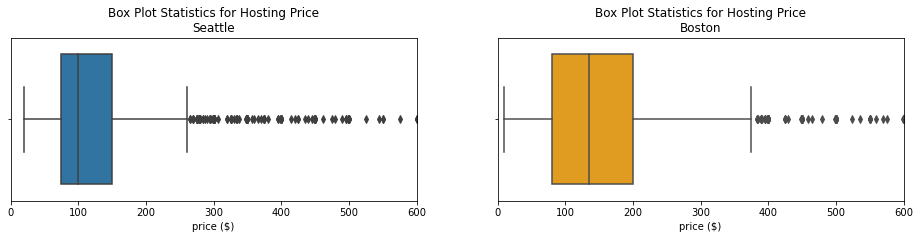

In [81]:
plt.figure(figsize=(16,3))

plt.subplot(1,2,1)
sns.boxplot(host_seattle.price)
plt.title('Box Plot Statistics for Hosting Price\nSeattle')
plt.xlabel('price ($)')
plt.xlim((0,600))

      
plt.subplot(1,2,2)
sns.boxplot(host_boston.price, color='orange')
plt.title('Box Plot Statistics for Hosting Price\nBoston')
plt.xlabel('price ($)')
plt.xlim((0,600))

plt.show()

Room price range is wider in Boston than Seattle. The median room price is also higher in Boston.

---
## `3.` How does the listing and price vary across neighborhood?

In [83]:
cols_neighbor = [
    'id', 'neighborhood_overview', 'street', 'neighbourhood', 'neighbourhood_cleansed', 
    'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 
    'smart_location', 'country_code', 'country', 'latitude', 'longitude',
    'is_location_exact', 'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 
    'availability_30', 'availability_60', 'availability_90', 
    'availability_365'
]

In [84]:
neighbor_seattle_temp = listings_sea[cols_neighbor].copy()
neighbor_boston_temp = listings_bos[cols_neighbor].copy()

### Data cleaning

In [85]:
def wrangle_airbnb_neighbor_data(df) :
    
    print(f'Original dataframe: {df.shape}')
    
    df_clean = df.copy()
    
    isDuplicated = df_clean.duplicated(subset=['id'], keep=False).sum()
    if( isDuplicated != 0 ) :
        df_clean = df_clean.drop_duplicates(subset=['id'], keep='last')
        
    df_clean.price = convert_price_float(df_clean.price)
    
    print(f'Cleaned dataframe: {df.shape}')
    
    return df_clean

In [86]:
neighbor_seattle = wrangle_airbnb_neighbor_data(neighbor_seattle_temp)
neighbor_boston = wrangle_airbnb_neighbor_data(neighbor_boston_temp)

Original dataframe: (3818, 30)
Cleaned dataframe: (3818, 30)
Original dataframe: (3585, 30)
Cleaned dataframe: (3585, 30)


### GeoPandas mapping
`geodata` folder contains shape files for Seattle and Boston

Reference: [GeoPandas 101: Plot any data with a latitude and longitude on a map](https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972)
  
Data source: 
- [City of Seattle](https://data-seattlecitygis.opendata.arcgis.com/datasets/city-clerk-neighborhoods)
- [Boston GIS](https://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0)

In [87]:
# Load shape files
seattle_map = gpd.read_file('geodata/seattle/City_Clerk_Neighborhoods.shp')
boston_map = gpd.read_file('geodata/boston/Boston_Neighborhoods.shp')

In [88]:
# Create a list of geometry points with longitude, latitude data
geometry_seattle = create_points_geometry(neighbor_seattle['longitude'], neighbor_seattle['latitude'])
geometry_boston = create_points_geometry(neighbor_boston['longitude'], neighbor_boston['latitude'])

In [92]:
# Create GeoDataFrame and set coordinates reference system (crs)
gdf_seattle = gpd.GeoDataFrame(neighbor_seattle, geometry = geometry_seattle)
gdf_boston = gpd.GeoDataFrame(neighbor_boston, geometry = geometry_boston)

In [126]:
# Additional feature 'geometry' added onto the original dataframes 
gdf_seattle.geometry[:2], gdf_boston.geometry[:2]

(0    POINT (-122.37103 47.63629)
 1    POINT (-122.36567 47.63912)
 Name: geometry, dtype: geometry,
 0    POINT (-71.13307 42.28262)
 1    POINT (-71.13437 42.28624)
 Name: geometry, dtype: geometry)

In [96]:
seattle_price_bins = gdf_seattle.price.describe()[3:]

seattle_price_group = pd.cut(x=gdf_seattle.price, bins=seattle_price_bins.values, 
                             labels=['quartile_1', 'quartile_2', 'quartile_3', 'quartile_4'])

gdf_seattle['price_group'] = seattle_price_group

In [97]:
boston_price_bins = gdf_boston.price.describe()[3:]

boston_price_group = pd.cut(x=gdf_boston.price, bins=boston_price_bins.values, 
                             labels=['quartile_1', 'quartile_2', 'quartile_3', 'quartile_4'])

gdf_boston['price_group'] = boston_price_group

### Visualization and exploration

<ipython-input-99-962080cbfd21>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[f'{lng:.2f}' for lng in gdf_seattle.longitude], rotation=45)


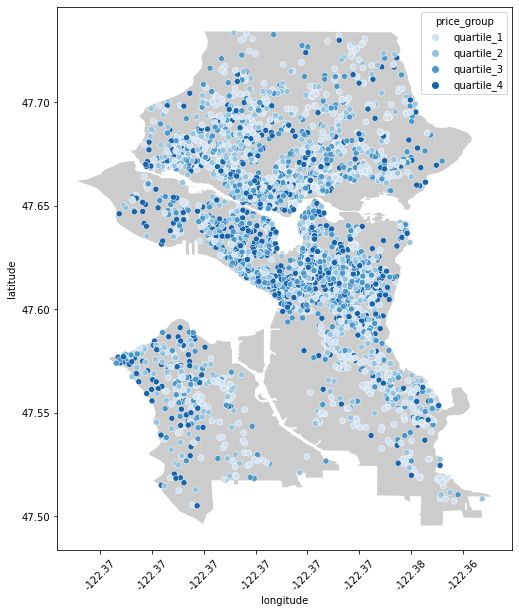

In [99]:
fig, ax = plt.subplots(figsize=(10,10))
seattle_map.plot(ax=ax, alpha=0.4, color='grey')
sns.scatterplot(data=gdf_seattle, x='longitude', y='latitude', hue='price_group', 
                palette='Blues')

ax.set_xticklabels(labels=[f'{lng:.2f}' for lng in gdf_seattle.longitude], rotation=45)

plt.show()

In [103]:
price_by_neighbor_sea = gdf_seattle.groupby('neighbourhood_cleansed').mean()['price']
price_by_neighbor_sea.sort_values(ascending=False)

neighbourhood_cleansed
Southeast Magnolia    231.705882
Portage Bay           227.857143
Westlake              194.470588
West Queen Anne       187.769231
Montlake              182.789474
                         ...    
North Delridge         76.375000
Georgetown             76.125000
South Delridge         74.666667
Olympic Hills          71.687500
Rainier Beach          68.555556
Name: price, Length: 87, dtype: float64

<ipython-input-108-256e109cccae>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[f'{lng:.2f}' for lng in gdf_boston.longitude], rotation=45)


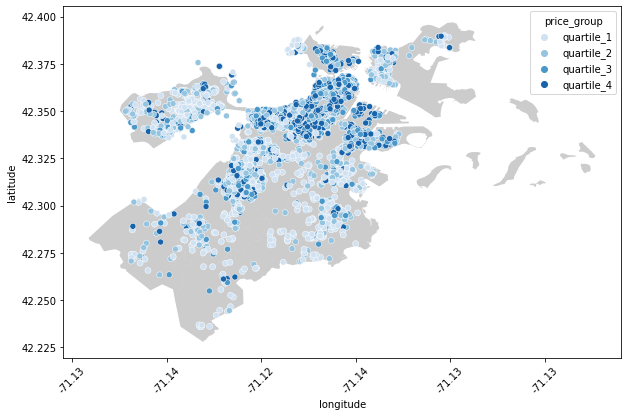

In [108]:
fig, ax = plt.subplots(figsize=(10,10))
boston_map.plot(ax=ax, alpha=0.4, color='grey')
sns.scatterplot(data=gdf_boston, x='longitude', y='latitude', hue='price_group', 
                palette='Blues')

ax.set_xticklabels(labels=[f'{lng:.2f}' for lng in gdf_boston.longitude], rotation=45)

plt.show()

In [102]:
price_by_neighbor_bos = gdf_boston.groupby('neighbourhood_cleansed').mean()['price']
price_by_neighbor_bos.sort_values(ascending=False)

neighbourhood_cleansed
South Boston Waterfront    306.060241
Bay Village                266.833333
Leather District           253.600000
Back Bay                   240.950331
Downtown                   236.459302
Chinatown                  232.352113
Beacon Hill                224.443299
Fenway                     220.393103
West End                   209.591837
South End                  204.349693
Charlestown                198.045045
North End                  195.678322
South Boston               187.609195
Roxbury                    146.333333
Jamaica Plain              138.478134
Longwood Medical Area      138.444444
Mission Hill               121.967742
East Boston                119.153333
Brighton                   118.767568
Allston                    112.307692
West Roxbury               107.108696
Roslindale                  98.428571
Dorchester                  91.639405
Hyde Park                   86.548387
Mattapan                    75.125000
Name: price, dtype: float64

---
<a id="bottom"></a>
[Go to the top](#top)

<a id="function"></a>
[Go to functions](#function)